<a href="https://colab.research.google.com/github/Abhayy-Mishra/Song_Recommendation_App/blob/main/song_recommendation_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle -q

In [ ]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


Data Collection

In [ ]:
from google.colab import drive
drive.mount('/drive')
df = pd.read_csv('/drive/My Drive/Dataset/spotify_millsongdata.csv')
df.head()

Mounted at /drive


,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
df.shape

(57650, 4)

In [ ]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [ ]:
top_artist = df['artist'].value_counts().head(10)
print("Top 10 artist in dataset :")
print(top_artist)

Top 10 artist in dataset :
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [ ]:
df = df.sample(10000)
df = df.drop('link', axis=1, errors='ignore').reset_index(drop=True)

In [ ]:
df.shape

(10000, 3)

In [ ]:
df.shape

(10000, 3)

In [ ]:
all_lyrics  = " ".join(df['text'].dropna())
wordcloud = WordCloud(width = 800, height = 400 , background_color= "white").generate(all_lyrics)

WORD CLOUD TO VISUALIZE THE MOST COMMON WORD IN DATASET:

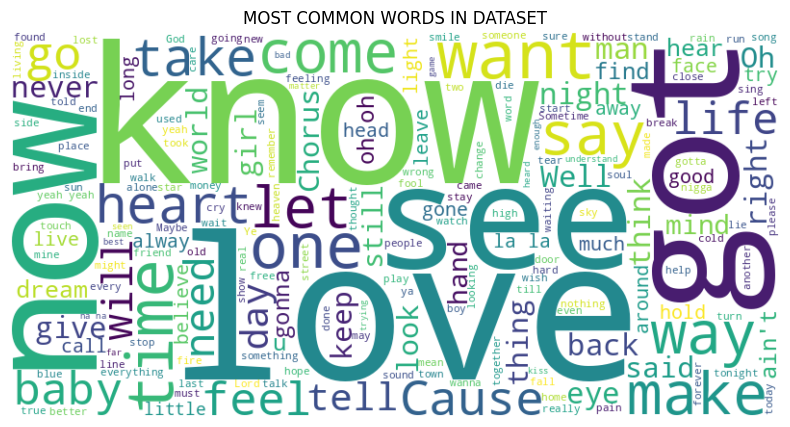

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("MOST COMMON WORDS IN DATASET")
plt.show()

DATA PREPROCESSING:

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
  #remove special characters and numbers
  text = re.sub(r"[^a-zA-Z\s]","",text)
  #convert text to lower case
  text = text.lower()
  #Tokenize and remove stopwords
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stopwords]
  return " ".join(tokens)

In [ ]:
#APPLY PREPROCESSING TO LYRICS:
df['cleaned_text']=df['text'].apply(preprocess_text)
# print(df)

In [ ]:
df.head()

,artist,song,text,cleaned_text
0,Ozzy Osbourne,Zombie Stomp,I don't need no doctor \r\nBut I need somethi...,dont need doctor need something kill pain dont...
1,Ne-Yo,My Road,Well I wear my clothes like this because I can...,well wear clothes like wear hair like walk aro...
2,Olivia Newton-John,If Love Is Real,If love is real why can't you take love \r\nA...,love real cant take love lock love away safe p...
3,Nitty Gritty Dirt Band,She,She \r\nShe came from the land of the cotton ...,came land cotton land nearly forgotten everyon...
4,Yeng Constantino,Time In,Ako ang bida ngayon \r\n(Masyado kang ambisyo...,ako ang bida ngayon masyado kang ambisyosa wag...


TF --> term frequency ,
TFIDF --> term frequency inverse document freqency
used for converting text into numbers as machine aslways stands numbers

In [ ]:
#Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])


In [ ]:
#compute cosine similarty:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:

# index, values
# 0, 1.0   --> exact similar to given song
# 2, 0.40
# 3, 0.51
# 6, 0.00      exact opposite to given song


In [ ]:
#RECOMMEND FUNCTIONS:
def recommend_songs(song_name, cosine_sim = cosine_sim , df = df , top_n= 5):
  #FIND INDEX OF THE SONGS
  idx = df[df['song'].str.lower()==song_name.lower()].index
  if len(idx)==0:
    return "Song not found in the dataset!"
  idx = idx[0]

  #GET SIMILARTY SCORE-->
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1],reverse = True)
  sim_scores = sim_scores[1:top_n+1]

  #GET SONG INDICES
  song_idices =  [i[0] for i in sim_scores]

  #RETURN TOP_N SIMILAR SONGS--->
  return df[['artist','song']].iloc[song_idices]




In [ ]:
df['song'][2]
print(df.head())

                   artist             song  \
0           Ozzy Osbourne     Zombie Stomp   
1                   Ne-Yo          My Road   
2      Olivia Newton-John  If Love Is Real   
3  Nitty Gritty Dirt Band              She   
4        Yeng Constantino          Time In   

                                                text  \
0  I don't need no doctor  \r\nBut I need somethi...   
1  Well I wear my clothes like this because I can...   
2  If love is real why can't you take love  \r\nA...   
3  She  \r\nShe came from the land of the cotton ...   
4  Ako ang bida ngayon  \r\n(Masyado kang ambisyo...   

                                        cleaned_text  
0  dont need doctor need something kill pain dont...  
1  well wear clothes like wear hair like walk aro...  
2  love real cant take love lock love away safe p...  
3  came land cotton land nearly forgotten everyon...  
4  ako ang bida ngayon masyado kang ambisyosa wag...  


In [ ]:
print("Recommendations songs for the song  - 'If love Is Real' ")
recommendatations = recommend_songs('If love Is Real')
print(recommendatations)

Recommendations songs for the song  - 'If love Is Real' 
          artist                  song
8255     Madonna          It's So Cool
9854         Who          Our Love Was
5321    Yoko Ono                My Man
2337  Beach Boys         I Do Love You
692   Air Supply  Who Will Love Me Now
